<a href="https://colab.research.google.com/github/Shakira4242/killtechnology-experimental-scripts/blob/main/Copy_of_ECCV_2020_Habitat_sim_Interactivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/facebookresearch/habitat-sim/blob/master/examples/tutorials/colabs/ECCV_2020_Interactivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Habitat-sim Interactivity

This use-case driven tutorial covers Habitat-sim interactivity, including:
- Adding new objects to a scene
- Kinematic object manipulation
- Physics simulation API
- Sampling valid object locations
- Generating a NavMesh including STATIC objects
- Agent embodiment and continuous control

In [1]:
# @title Installation { display-mode: "form" }
# @markdown (double click to show code).

!curl -L https://raw.githubusercontent.com/facebookresearch/habitat-sim/master/examples/colab_utils/colab_install.sh | NIGHTLY=true bash -s
!wget -c http://dl.fbaipublicfiles.com/habitat/mp3d_example.zip && unzip -o mp3d_example.zip -d /content/habitat-sim/data/scene_datasets/mp3d/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2470  100  2470    0     0  26000      0 --:--:-- --:--:-- --:--:-- 26000
Habitat is already installed. Aborting...
--2020-12-18 03:24:21--  http://dl.fbaipublicfiles.com/habitat/mp3d_example.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  mp3d_example.zip
  inflating: /content/habitat-sim/data/scene_datasets/mp3d/17DRP5sb8fy/17DRP5sb8fy.glb  
  inflating: /content/habitat-sim/data/scene_datasets/mp3d/17DRP5sb8fy/17DRP5sb8fy.navmesh  
  inflating: /content/habitat-sim/data/scene_datasets/mp3d/17DRP5sb8fy/17DRP5sb8fy.house  
  inflati

In [2]:
# @title Path Setup and Imports { display-mode: "form" }
# @markdown (double click to show code).

%cd /content/habitat-sim
## [setup]
import math
import os
import random
import sys

import git
import magnum as mn
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
from PIL import Image

import habitat_sim
from habitat_sim.utils import common as ut
from habitat_sim.utils import viz_utils as vut

try:
    import ipywidgets as widgets
    from IPython.display import display as ipydisplay

    # For using jupyter/ipywidget IO components

    HAS_WIDGETS = True
except ImportError:
    HAS_WIDGETS = False


if "google.colab" in sys.modules:
    os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"

repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
%cd $dir_path
data_path = os.path.join(dir_path, "data")
output_directory = "examples/tutorials/interactivity_output/"  # @param {type:"string"}
output_path = os.path.join(dir_path, output_directory)
if not os.path.exists(output_path):
    os.mkdir(output_path)

# define some globals the first time we run.
if "sim" not in globals():
    global sim
    sim = None
    global obj_attr_mgr
    obj_attr_mgr = None
    global prim_attr_mgr
    obj_attr_mgr = None
    global stage_attr_mgr
    stage_attr_mgr = None

/content/habitat-sim
/content/habitat-sim


In [3]:
# @title Define Configuration Utility Functions { display-mode: "form" }
# @markdown (double click to show code)

# @markdown This cell defines a number of utility functions used throughout the tutorial to make simulator reconstruction easy:
# @markdown - make_cfg
# @markdown - make_default_settings
# @markdown - make_simulator_from_settings


def make_cfg(settings):
    sim_cfg = habitat_sim.SimulatorConfiguration()
    sim_cfg.gpu_device_id = 0
    sim_cfg.scene_id = settings["scene"]
    sim_cfg.enable_physics = settings["enable_physics"]

    # Note: all sensors must have the same resolution
    sensors = {
        "color_sensor_1st_person": {
            "sensor_type": habitat_sim.SensorType.COLOR,
            "resolution": [settings["height"], settings["width"]],
            "position": [0.0, settings["sensor_height"], 0.0],
            "orientation": [settings["sensor_pitch"], 0.0, 0.0],
        },
        "depth_sensor_1st_person": {
            "sensor_type": habitat_sim.SensorType.DEPTH,
            "resolution": [settings["height"], settings["width"]],
            "position": [0.0, settings["sensor_height"], 0.0],
            "orientation": [settings["sensor_pitch"], 0.0, 0.0],
        },
        "semantic_sensor_1st_person": {
            "sensor_type": habitat_sim.SensorType.SEMANTIC,
            "resolution": [settings["height"], settings["width"]],
            "position": [0.0, settings["sensor_height"], 0.0],
            "orientation": [settings["sensor_pitch"], 0.0, 0.0],
        },
        # configure the 3rd person cam specifically:
        "color_sensor_3rd_person": {
            "sensor_type": habitat_sim.SensorType.COLOR,
            "resolution": [settings["height"], settings["width"]],
            "position": [0.0, settings["sensor_height"] + 0.2, 0.2],
            "orientation": np.array([-math.pi / 4, 0, 0]),
        },
    }

    sensor_specs = []
    for sensor_uuid, sensor_params in sensors.items():
        if settings[sensor_uuid]:
            sensor_spec = habitat_sim.SensorSpec()
            sensor_spec.uuid = sensor_uuid
            sensor_spec.sensor_type = sensor_params["sensor_type"]
            sensor_spec.resolution = sensor_params["resolution"]
            sensor_spec.position = sensor_params["position"]
            sensor_spec.orientation = sensor_params["orientation"]

            sensor_specs.append(sensor_spec)

    # Here you can specify the amount of displacement in a forward action and the turn angle
    agent_cfg = habitat_sim.agent.AgentConfiguration()
    agent_cfg.sensor_specifications = sensor_specs

    return habitat_sim.Configuration(sim_cfg, [agent_cfg])


def make_default_settings():
    settings = {
        "width": 720,  # Spatial resolution of the observations
        "height": 544,
        "scene": "./data/scene_datasets/habitat-test-scenes/apartment_1.glb",  # Scene path
        "default_agent": 0,
        "sensor_height": 1.5,  # Height of sensors in meters
        "sensor_pitch": -math.pi / 8.0,  # sensor pitch (x rotation in rads)
        "color_sensor_1st_person": True,  # RGB sensor
        "color_sensor_3rd_person": False,  # RGB sensor 3rd person
        "depth_sensor_1st_person": False,  # Depth sensor
        "semantic_sensor_1st_person": False,  # Semantic sensor
        "seed": 1,
        "enable_physics": True,  # enable dynamics simulation
    }
    return settings


def make_simulator_from_settings(sim_settings):
    cfg = make_cfg(sim_settings)
    # clean-up the current simulator instance if it exists
    global sim
    global obj_attr_mgr
    global prim_attr_mgr
    global stage_attr_mgr
    if sim != None:
        sim.close()
    # initialize the simulator
    sim = habitat_sim.Simulator(cfg)
    # Managers of various Attributes templates
    obj_attr_mgr = sim.get_object_template_manager()
    obj_attr_mgr.load_configs(str(os.path.join(data_path, "objects")))
    prim_attr_mgr = sim.get_asset_template_manager()
    stage_attr_mgr = sim.get_stage_template_manager()

In [4]:
# @title Define Simulation Utility Functions { display-mode: "form" }
# @markdown (double click to show code)

# @markdown - remove_all_objects
# @markdown - simulate
# @markdown - sample_object_state


def remove_all_objects(sim):
    for obj_id in sim.get_existing_object_ids():
        sim.remove_object(obj_id)


def simulate(sim, dt=1.0, get_frames=True):
    # simulate dt seconds at 60Hz to the nearest fixed timestep
    print("Simulating " + str(dt) + " world seconds.")
    observations = []
    start_time = sim.get_world_time()
    while sim.get_world_time() < start_time + dt:
        sim.step_physics(1.0 / 60.0)
        if get_frames:
            observations.append(sim.get_sensor_observations())
    return observations


# Set an object transform relative to the agent state
def set_object_state_from_agent(
    sim,
    ob_id,
    offset=np.array([0, 2.0, -1.5]),
    orientation=mn.Quaternion(((0, 0, 0), 1)),
):
    agent_transform = sim.agents[0].scene_node.transformation_matrix()
    ob_translation = agent_transform.transform_point(offset)
    sim.set_translation(ob_translation, ob_id)
    sim.set_rotation(orientation, ob_id)


# sample a random valid state for the object from the scene bounding box or navmesh
def sample_object_state(
    sim, object_id, from_navmesh=True, maintain_object_up=True, max_tries=100, bb=None
):
    # check that the object is not STATIC
    if sim.get_object_motion_type(object_id) is habitat_sim.physics.MotionType.STATIC:
        print("sample_object_state : Object is STATIC, aborting.")
    if from_navmesh:
        if not sim.pathfinder.is_loaded:
            print("sample_object_state : No pathfinder, aborting.")
            return False
    elif not bb:
        print(
            "sample_object_state : from_navmesh not specified and no bounding box provided, aborting."
        )
        return False
    tries = 0
    valid_placement = False
    # Note: following assumes sim was not reconfigured without close
    scene_collision_margin = stage_attr_mgr.get_template_by_ID(0).margin
    while not valid_placement and tries < max_tries:
        tries += 1
        # initialize sample location to random point in scene bounding box
        sample_location = np.array([0, 0, 0])
        if from_navmesh:
            # query random navigable point
            sample_location = sim.pathfinder.get_random_navigable_point()
        else:
            sample_location = np.random.uniform(bb.min, bb.max)
        # set the test state
        sim.set_translation(sample_location, object_id)
        if maintain_object_up:
            # random rotation only on the Y axis
            y_rotation = mn.Quaternion.rotation(
                mn.Rad(random.random() * 2 * math.pi), mn.Vector3(0, 1.0, 0)
            )
            sim.set_rotation(y_rotation * sim.get_rotation(object_id), object_id)
        else:
            # unconstrained random rotation
            sim.set_rotation(ut.random_quaternion(), object_id)

        # raise object such that lowest bounding box corner is above the navmesh sample point.
        if from_navmesh:
            obj_node = sim.get_object_scene_node(object_id)
            xform_bb = habitat_sim.geo.get_transformed_bb(
                obj_node.cumulative_bb, obj_node.transformation
            )
            # also account for collision margin of the scene
            y_translation = mn.Vector3(
                0, xform_bb.size_y() / 2.0 + scene_collision_margin, 0
            )
            sim.set_translation(
                y_translation + sim.get_translation(object_id), object_id
            )

        # test for penetration with the environment
        if not sim.contact_test(object_id):
            valid_placement = True

    if not valid_placement:
        return False
    return True

In [5]:
# @title Define Visualization Utility Function { display-mode: "form" }
# @markdown (double click to show code)
# @markdown - display_sample

# Change to do something like this maybe: https://stackoverflow.com/a/41432704
def display_sample(
    rgb_obs, semantic_obs=np.array([]), depth_obs=np.array([]), key_points=None
):
    from habitat_sim.utils.common import d3_40_colors_rgb

    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")

    arr = [rgb_img]
    titles = ["rgb"]
    if semantic_obs.size != 0:
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)
        titles.append("semantic")

    if depth_obs.size != 0:
        depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")
        arr.append(depth_img)
        titles.append("depth")

    plt.figure(figsize=(12, 8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        # plot points on images
        if key_points is not None:
            for point in key_points:
                plt.plot(point[0], point[1], marker="o", markersize=10, alpha=0.8)
        plt.imshow(data)

    plt.show(block=False)


if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("--no-display", dest="display", action="store_false")
    parser.add_argument("--no-make-video", dest="make_video", action="store_false")
    parser.set_defaults(show_video=True, make_video=True)
    args, _ = parser.parse_known_args()
    show_video = args.display
    display = args.display
    make_video = args.make_video
else:
    show_video = False
    make_video = False
    display = False

In [6]:
# @title Define Colab GUI Utility Functions { display-mode: "form" }
# @markdown (double click to show code)

# Event handler for dropdowns displaying file-based object handles
def on_file_obj_ddl_change(ddl_values):
    global sel_file_obj_handle
    sel_file_obj_handle = ddl_values["new"]
    return sel_file_obj_handle


# Event handler for dropdowns displaying prim-based object handles
def on_prim_obj_ddl_change(ddl_values):
    global sel_prim_obj_handle
    sel_prim_obj_handle = ddl_values["new"]
    return sel_prim_obj_handle


# Event handler for dropdowns displaying asset handles
def on_prim_ddl_change(ddl_values):
    global sel_asset_handle
    sel_asset_handle = ddl_values["new"]
    return sel_asset_handle


# Build a dropdown list holding obj_handles and set its event handler
def set_handle_ddl_widget(obj_handles, handle_types, sel_handle, on_change):
    sel_handle = obj_handles[0]
    descStr = handle_types + " Template Handles:"
    style = {"description_width": "300px"}
    obj_ddl = widgets.Dropdown(
        options=obj_handles,
        value=sel_handle,
        description=descStr,
        style=style,
        disabled=False,
        layout={"width": "max-content"},
    )

    obj_ddl.observe(on_change, names="value")
    return obj_ddl, sel_handle


def set_button_launcher(desc):
    button = widgets.Button(
        description=desc,
        layout={"width": "max-content"},
    )
    return button


def make_sim_and_vid_button(prefix, dt=1.0):
    if not HAS_WIDGETS:
        return

    def on_sim_click(b):
        observations = simulate(sim, dt=dt)
        vut.make_video(
            observations, "color_sensor_1st_person", "color", output_path + prefix
        )

    sim_and_vid_btn = set_button_launcher("Simulate and Make Video")
    sim_and_vid_btn.on_click(on_sim_click)
    ipydisplay(sim_and_vid_btn)


def make_clear_all_objects_button():
    if not HAS_WIDGETS:
        return

    def on_clear_click(b):
        remove_all_objects(sim)

    clear_objs_button = set_button_launcher("Clear all objects")
    clear_objs_button.on_click(on_clear_click)
    ipydisplay(clear_objs_button)


# Builds widget-based UI components
def build_widget_ui(obj_attr_mgr, prim_attr_mgr):
    # Holds the user's desired file-based object template handle
    global sel_file_obj_handle
    sel_file_obj_handle = ""

    # Holds the user's desired primitive-based object template handle
    global sel_prim_obj_handle
    sel_prim_obj_handle = ""

    # Holds the user's desired primitive asset template handle
    global sel_asset_handle
    sel_asset_handle = ""

    # Construct DDLs and assign event handlers
    # All file-based object template handles
    file_obj_handles = obj_attr_mgr.get_file_template_handles()
    prim_obj_handles = obj_attr_mgr.get_synth_template_handles()
    prim_asset_handles = prim_attr_mgr.get_template_handles()
    if not HAS_WIDGETS:
        sel_file_obj_handle = file_obj_handles[0]
        sel_prim_obj_handle = prim_obj_handles[0]
        sel_prim_obj_handle = prim_asset_handles[0]
        return
    file_obj_ddl, sel_file_obj_handle = set_handle_ddl_widget(
        file_obj_handles,
        "File-based Object",
        sel_file_obj_handle,
        on_file_obj_ddl_change,
    )
    # All primitive asset-based object template handles
    prim_obj_ddl, sel_prim_obj_handle = set_handle_ddl_widget(
        prim_obj_handles,
        "Primitive-based Object",
        sel_prim_obj_handle,
        on_prim_obj_ddl_change,
    )
    # All primitive asset handles template handles
    prim_asset_ddl, sel_asset_handle = set_handle_ddl_widget(
        prim_asset_handles, "Primitive Asset", sel_asset_handle, on_prim_ddl_change
    )
    # Display DDLs
    ipydisplay(file_obj_ddl)
    ipydisplay(prim_obj_ddl)
    ipydisplay(prim_asset_ddl)

In [7]:
# @title Initialize Simulator and Load Scene { display-mode: "form" }

# convienience functions defined in Utility cell manage global variables
sim_settings = make_default_settings()
# set globals: sim,
make_simulator_from_settings(sim_settings)

I1218 03:24:26.844203 2859 simulator.py:213] Loaded navmesh ./data/scene_datasets/habitat-test-scenes/apartment_1.navmesh


#Interactivity in Habitat-sim

This tutorial covers how to configure and use the Habitat-sim object manipulation API to setup and run physical interaction simulations.

## Outline:
This section is divided into four use-case driven sub-sections:
1.   Introduction to Interactivity
2.   Physical Reasoning
3.   Generating Scene Clutter on the NavMesh
4.   Continuous Embodied Navigation

For more tutorial examples and details see the [Interactive Rigid Objects tutorial](https://aihabitat.org/docs/habitat-sim/rigid-object-tutorial.html) also available for Colab [here](https://github.com/facebookresearch/habitat-sim/blob/master/examples/tutorials/colabs/rigid_object_tutorial.ipynb).





## Introduction to Interactivity

####Easily add an object and simulate!



In [8]:
# @title Select a Simulation Object Template: { display-mode: "form" }
# @markdown Use the dropdown menu below to select an object template for use in the following examples.

# @markdown File-based object templates are loaded from and named after an asset file (e.g. banana.glb), while Primitive-based object templates are generated programmatically (e.g. uv_sphere) with handles (name/key for reference) uniquely generated from a specific parameterization.

# @markdown See the Advanced Features tutorial for more details about asset configuration.

build_widget_ui(obj_attr_mgr, prim_attr_mgr)

Dropdown(description='File-based Object Template Handles:', layout=Layout(width='max-content'), options=('/con…

Dropdown(description='Primitive-based Object Template Handles:', layout=Layout(width='max-content'), options=(…

Dropdown(description='Primitive Asset Template Handles:', layout=Layout(width='max-content'), options=('capsul…

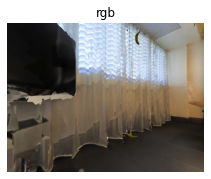

Button(description='Simulate and Make Video', layout=Layout(width='max-content'), style=ButtonStyle())

Button(description='Clear all objects', layout=Layout(width='max-content'), style=ButtonStyle())

In [23]:
# @title Add either a File-based or Primitive Asset-based object to the scene at a user-specified location.{ display-mode: "form" }
# @markdown Running this will add a physically-modelled object of the selected type to the scene at the location specified by user, simulate forward for a few seconds and save a movie of the results.

# @markdown Choose either the primitive or file-based template recently selected in the dropdown:
obj_template_handle = sel_file_obj_handle
asset_tempalte_handle = sel_asset_handle
object_type = "File-based"  # @param ["File-based","Primitive-based"]
if "File" in object_type:
    # Handle File-based object handle
    obj_template_handle = sel_file_obj_handle
elif "Primitive" in object_type:
    # Handle Primitive-based object handle
    obj_template_handle = sel_prim_obj_handle
else:
    # Unknown - defaults to file-based
    pass

# @markdown Configure the initial object location (local offset from the agent body node):
# default : offset=np.array([0,2.0,-1.5]), orientation=np.quaternion(1,0,0,0)
offset_x = 0.5  # @param {type:"slider", min:-2, max:2, step:0.1}
offset_y = 1.5  # @param {type:"slider", min:0, max:3.0, step:0.1}
offset_z = -1.5  # @param {type:"slider", min:-3, max:0, step:0.1}
offset = np.array([offset_x, offset_y, offset_z])

# @markdown Configure the initial object orientation via local Euler angle (degrees):
orientation_x = 0  # @param {type:"slider", min:-180, max:180, step:1}
orientation_y = 0  # @param {type:"slider", min:-180, max:180, step:1}
orientation_z = 0  # @param {type:"slider", min:-180, max:180, step:1}

# compose the rotations
rotation_x = mn.Quaternion.rotation(mn.Deg(orientation_x), mn.Vector3(1.0, 0, 0))
rotation_y = mn.Quaternion.rotation(mn.Deg(orientation_y), mn.Vector3(1.0, 0, 0))
rotation_z = mn.Quaternion.rotation(mn.Deg(orientation_z), mn.Vector3(1.0, 0, 0))
orientation = rotation_z * rotation_y * rotation_x

# Add object instantiated by desired template using template handle
obj_id_1 = sim.add_object_by_handle(obj_template_handle)

# @markdown Note: agent local coordinate system is Y up and -Z forward.
# Move object to be in front of the agent
set_object_state_from_agent(sim, obj_id_1, offset=offset, orientation=orientation)

# display a still frame of the scene after the object is added if RGB sensor is enabled
observations = sim.get_sensor_observations()
if display and sim_settings["color_sensor_1st_person"]:
    display_sample(observations["color_sensor_1st_person"])

example_type = "adding objects test"
make_sim_and_vid_button(example_type)
make_clear_all_objects_button()





## Physical Reasoning

This section demonstrates simple setups for physical reasoning tasks in Habitat-sim with a fixed camera position collecting data:
- Scripted vs. Dynamic Motion
- Object Permanence
- Physical plausibility classification
- Trajectory Prediction

In [10]:
# @title Select object templates from the GUI: { display-mode: "form" }

build_widget_ui(obj_attr_mgr, prim_attr_mgr)

Dropdown(description='File-based Object Template Handles:', layout=Layout(width='max-content'), options=('/con…

Dropdown(description='Primitive-based Object Template Handles:', layout=Layout(width='max-content'), options=(…

Dropdown(description='Primitive Asset Template Handles:', layout=Layout(width='max-content'), options=('capsul…

In [11]:
# @title Scripted vs. Dynamic Motion { display-mode: "form" }
# @markdown A quick script to generate video data for AI classification of dynamically dropping vs. kinematically moving objects.
remove_all_objects(sim)
# @markdown Set the scene as dynamic or kinematic:
scenario_is_kinematic = True  # @param {type:"boolean"}

# add the selected object
obj_id_1 = sim.add_object_by_handle(sel_file_obj_handle)

# place the object
set_object_state_from_agent(
    sim, obj_id_1, offset=np.array([0, 2.0, -1.0]), orientation=ut.random_quaternion()
)

if scenario_is_kinematic:
    # use the velocity control struct to setup a constant rate kinematic motion
    sim.set_object_motion_type(habitat_sim.physics.MotionType.KINEMATIC, obj_id_1)
    vel_control = sim.get_object_velocity_control(obj_id_1)
    vel_control.controlling_lin_vel = True
    vel_control.linear_velocity = np.array([0, -1.0, 0])

# simulate and collect observations
example_type = "kinematic vs dynamic"
observations = simulate(sim, dt=2.0)
if make_video:
    vut.make_video(
        observations,
        "color_sensor_1st_person",
        "color",
        output_path + example_type,
        open_vid=show_video,
    )

remove_all_objects(sim)

Simulating 2.0 world seconds.
Encoding the video: /content/habitat-sim/examples/tutorials/interactivity_output/kinematic vs dynamic.mp4 


In [12]:
# @title Object Permanence { display-mode: "form" }
# @markdown This example script demonstrates a possible object permanence task.
# @markdown Two objects are dropped behind an occluder. One is removed while occluded.
remove_all_objects(sim)

# @markdown 1. Add the two dynamic objects.
# add the selected objects
obj_id_1 = sim.add_object_by_handle(sel_file_obj_handle)
obj_id_2 = sim.add_object_by_handle(sel_file_obj_handle)

# place the objects
set_object_state_from_agent(
    sim, obj_id_1, offset=np.array([0.5, 2.0, -1.0]), orientation=ut.random_quaternion()
)
set_object_state_from_agent(
    sim,
    obj_id_2,
    offset=np.array([-0.5, 2.0, -1.0]),
    orientation=ut.random_quaternion(),
)

# @markdown 2. Configure and add an occluder from a scaled cube primitive.
# Get a default cube primitive template
obj_attr_mgr = sim.get_object_template_manager()
cube_handle = obj_attr_mgr.get_template_handles("cube")[0]
cube_template_cpy = obj_attr_mgr.get_template_by_handle(cube_handle)
# Modify the template's configured scale.
cube_template_cpy.scale = np.array([0.32, 0.075, 0.01])
# Register the modified template under a new name.
obj_attr_mgr.register_template(cube_template_cpy, "occluder_cube")
# Instance and place the occluder object from the template.
occluder_id = sim.add_object_by_handle("occluder_cube")
set_object_state_from_agent(sim, occluder_id, offset=np.array([0.0, 1.4, -0.4]))
sim.set_object_motion_type(habitat_sim.physics.MotionType.KINEMATIC, occluder_id)
# fmt off
# @markdown 3. Simulate at 60Hz, removing one object when it's center of mass drops below that of the occluder.
# fmt on
# Simulate and remove object when it passes the midpoint of the occluder
dt = 2.0
print("Simulating " + str(dt) + " world seconds.")
observations = []
# simulate at 60Hz to the nearest fixed timestep
start_time = sim.get_world_time()
while sim.get_world_time() < start_time + dt:
    sim.step_physics(1.0 / 60.0)
    # remove the object once it passes the occluder center
    if (
        obj_id_2 in sim.get_existing_object_ids()
        and sim.get_translation(obj_id_2)[1] <= sim.get_translation(occluder_id)[1]
    ):
        sim.remove_object(obj_id_2)
    observations.append(sim.get_sensor_observations())

example_type = "object permanence"
if make_video:
    vut.make_video(
        observations,
        "color_sensor_1st_person",
        "color",
        output_path + example_type,
        open_vid=show_video,
    )
remove_all_objects(sim)

Simulating 2.0 world seconds.
Encoding the video: /content/habitat-sim/examples/tutorials/interactivity_output/object permanence.mp4 


In [13]:
# @title Physical Plausibility Classification { display-mode: "form" }
# @markdown This example demonstrates a physical plausibility expirement. A sphere
# @markdown is dropped onto the back of a couch to roll onto the floor. Optionally,
# @markdown an invisible plane is introduced for the sphere to roll onto producing
# @markdown non-physical motion.

introduce_surface = True  # @param{type:"boolean"}

remove_all_objects(sim)

# add a rolling object
obj_attr_mgr = sim.get_object_template_manager()
sphere_handle = obj_attr_mgr.get_template_handles("uvSphereSolid")[0]
obj_id_1 = sim.add_object_by_handle(sphere_handle)
set_object_state_from_agent(sim, obj_id_1, offset=np.array([1.0, 1.6, -1.95]))

if introduce_surface:
    # optionally add invisible surface
    cube_handle = obj_attr_mgr.get_template_handles("cube")[0]
    cube_template_cpy = obj_attr_mgr.get_template_by_handle(cube_handle)
    # Modify the template.
    cube_template_cpy.scale = np.array([1.0, 0.04, 1.0])
    surface_is_visible = False  # @param{type:"boolean"}
    cube_template_cpy.is_visibile = surface_is_visible
    # Register the modified template under a new name.
    obj_attr_mgr.register_template(cube_template_cpy, "invisible_surface")

    # Instance and place the surface object from the template.
    surface_id = sim.add_object_by_handle("invisible_surface")
    set_object_state_from_agent(sim, surface_id, offset=np.array([0.4, 0.88, -1.6]))
    sim.set_object_motion_type(habitat_sim.physics.MotionType.STATIC, surface_id)


example_type = "physical plausibility"
observations = simulate(sim, dt=3.0)
if make_video:
    vut.make_video(
        observations,
        "color_sensor_1st_person",
        "color",
        output_path + example_type,
        open_vid=show_video,
    )
remove_all_objects(sim)

Simulating 3.0 world seconds.
Encoding the video: /content/habitat-sim/examples/tutorials/interactivity_output/physical plausibility.mp4 


In [14]:
# @title Trajectory Prediction { display-mode: "form" }
# @markdown This example demonstrates setup of a trajectory prediction task.
# @markdown Boxes are placed in a target zone and a sphere is given an initial
# @markdown velocity with the goal of knocking the boxes off the counter.

# @markdown ---
# @markdown Configure Parameters:

obj_attr_mgr = sim.get_object_template_manager()
remove_all_objects(sim)

seed = 2  # @param{type:"integer"}
random.seed(seed)
sim.seed(seed)
np.random.seed(seed)

# setup agent state manually to face the bar
agent_state = sim.agents[0].state
agent_state.position = np.array([-1.97496, 0.072447, -2.0894])
agent_state.rotation = ut.quat_from_coeffs([0, -1, 0, 0])
sim.agents[0].set_state(agent_state)

# load the target objects
cheezit_handle = obj_attr_mgr.get_template_handles("cheezit")[0]
# create range from center and half-extent
target_zone = mn.Range3D.from_center(
    mn.Vector3(-2.07496, 1.07245, -0.2894), mn.Vector3(0.5, 0.05, 0.1)
)
num_targets = 9  # @param{type:"integer"}
for _target in range(num_targets):
    obj_id = sim.add_object_by_handle(cheezit_handle)
    # rotate boxes off of their sides
    rotate = mn.Quaternion.rotation(mn.Rad(-mn.math.pi_half), mn.Vector3(1.0, 0, 0))
    sim.set_rotation(rotate, obj_id)
    # sample state from the target zone
    if not sample_object_state(sim, obj_id, False, True, 100, target_zone):
        sim.remove_object(obj_id)


show_target_zone = False  # @param{type:"boolean"}
if show_target_zone:
    # Get and modify the wire cube template from the range
    cube_handle = obj_attr_mgr.get_template_handles("cubeWireframe")[0]
    cube_template_cpy = obj_attr_mgr.get_template_by_handle(cube_handle)
    cube_template_cpy.scale = target_zone.size()
    cube_template_cpy.is_collidable = False
    # Register the modified template under a new name.
    obj_attr_mgr.register_template(cube_template_cpy, "target_zone")
    # instance and place the object from the template
    target_zone_id = sim.add_object_by_handle("target_zone")
    sim.set_translation(target_zone.center(), target_zone_id)
    sim.set_object_motion_type(habitat_sim.physics.MotionType.STATIC, target_zone_id)
    # print("target_zone_center = " + str(sim.get_translation(target_zone_id)))

# @markdown ---
# @markdown ###Ball properties:
# load the ball
sphere_handle = obj_attr_mgr.get_template_handles("uvSphereSolid")[0]
sphere_template_cpy = obj_attr_mgr.get_template_by_handle(sphere_handle)
# @markdown Mass:
ball_mass = 5.01  # @param {type:"slider", min:0.01, max:50.0, step:0.01}
sphere_template_cpy.mass = ball_mass
obj_attr_mgr.register_template(sphere_template_cpy, "ball")

ball_id = sim.add_object_by_handle("ball")
set_object_state_from_agent(sim, ball_id, offset=np.array([0, 1.4, 0]))

# @markdown Initial linear velocity (m/sec):
lin_vel_x = 0  # @param {type:"slider", min:-10, max:10, step:0.1}
lin_vel_y = 1  # @param {type:"slider", min:-10, max:10, step:0.1}
lin_vel_z = 5  # @param {type:"slider", min:0, max:10, step:0.1}
initial_linear_velocity = mn.Vector3(lin_vel_x, lin_vel_y, lin_vel_z)
sim.set_linear_velocity(initial_linear_velocity, ball_id)

# @markdown Initial angular velocity (rad/sec):
ang_vel_x = 0  # @param {type:"slider", min:-100, max:100, step:0.1}
ang_vel_y = 0  # @param {type:"slider", min:-100, max:100, step:0.1}
ang_vel_z = 0  # @param {type:"slider", min:-100, max:100, step:0.1}
initial_angular_velocity = mn.Vector3(ang_vel_x, ang_vel_y, ang_vel_z)
sim.set_angular_velocity(initial_angular_velocity, ball_id)

example_type = "trajectory prediction"
observations = simulate(sim, dt=3.0)
if make_video:
    vut.make_video(
        observations,
        "color_sensor_1st_person",
        "color",
        output_path + example_type,
        open_vid=show_video,
    )
remove_all_objects(sim)

Simulating 3.0 world seconds.
Encoding the video: /content/habitat-sim/examples/tutorials/interactivity_output/trajectory prediction.mp4 


## Generating Scene Clutter on the NavMesh

The NavMesh can be used to place objects on surfaces in the scene. Once objects are placed they can be set to MotionType::STATIC, indiciating that they are not moveable (kinematics and dynamics are disabled for STATIC objects). The NavMesh can then be recomputed including STATIC object meshes in the voxelization.

This example demonstrates using the NavMesh to generate a cluttered scene for navigation. In this script we will:

- Place objects off the NavMesh
- Set them to MotionType::STATIC
- Recompute the NavMesh including STATIC objects
- Visualize the results

In [15]:
# @title Initialize Simulator and Load Scene { display-mode: "form" }
# @markdown (load the apartment_1 scene for clutter generation in an open space)
sim_settings = make_default_settings()
sim_settings["scene"] = "./data/scene_datasets/habitat-test-scenes/apartment_1.glb"
sim_settings["sensor_pitch"] = 0

make_simulator_from_settings(sim_settings)

I1218 03:24:34.888607 2859 simulator.py:213] Loaded navmesh ./data/scene_datasets/habitat-test-scenes/apartment_1.navmesh


In [16]:
# @title Select clutter object from the GUI: { display-mode: "form" }

build_widget_ui(obj_attr_mgr, prim_attr_mgr)

Dropdown(description='File-based Object Template Handles:', layout=Layout(width='max-content'), options=('/con…

Dropdown(description='Primitive-based Object Template Handles:', layout=Layout(width='max-content'), options=(…

Dropdown(description='Primitive Asset Template Handles:', layout=Layout(width='max-content'), options=('capsul…

In [17]:
# @title Clutter Generation Script
# @markdown Configure some example parameters:

seed = 2  # @param {type:"integer"}
random.seed(seed)
sim.seed(seed)
np.random.seed(seed)

# position the agent
sim.agents[0].scene_node.translation = mn.Vector3(0.5, -1.60025, 6.15)
print(sim.agents[0].scene_node.rotation)
agent_orientation_y = -23  # @param{type:"integer"}
sim.agents[0].scene_node.rotation = mn.Quaternion.rotation(
    mn.Deg(agent_orientation_y), mn.Vector3(0, 1.0, 0)
)

num_objects = 10  # @param {type:"slider", min:0, max:20, step:1}
object_scale = 5  # @param {type:"slider", min:1.0, max:10.0, step:0.1}

# scale up the selected object
sel_obj_template_cpy = obj_attr_mgr.get_template_by_handle(sel_file_obj_handle)
sel_obj_template_cpy.scale = mn.Vector3(object_scale)
obj_attr_mgr.register_template(sel_obj_template_cpy, "scaled_sel_obj")

# add the selected object
sim.navmesh_visualization = True
remove_all_objects(sim)
fails = 0
for _obj in range(num_objects):
    obj_id_1 = sim.add_object_by_handle("scaled_sel_obj")

    # place the object
    placement_success = sample_object_state(
        sim, obj_id_1, from_navmesh=True, maintain_object_up=True, max_tries=100
    )
    if not placement_success:
        fails += 1
        sim.remove_object(obj_id_1)
    else:
        # set the objects to STATIC so they can be added to the NavMesh
        sim.set_object_motion_type(habitat_sim.physics.MotionType.STATIC, obj_id_1)

print("Placement fails = " + str(fails) + "/" + str(num_objects))

# recompute the NavMesh with STATIC objects
navmesh_settings = habitat_sim.NavMeshSettings()
navmesh_settings.set_defaults()
navmesh_success = sim.recompute_navmesh(
    sim.pathfinder, navmesh_settings, include_static_objects=True
)

# simulate and collect observations
example_type = "clutter generation"
observations = simulate(sim, dt=2.0)
if make_video:
    vut.make_video(
        observations,
        "color_sensor_1st_person",
        "color",
        output_path + example_type,
        open_vid=show_video,
    )
remove_all_objects(sim)
sim.navmesh_visualization = False

Quaternion({0, 2.45858e-05, 0}, 1)
Placement fails = 0/10
Simulating 2.0 world seconds.
Encoding the video: /content/habitat-sim/examples/tutorials/interactivity_output/clutter generation.mp4 


## Embodied Continuous Navigation

The following example demonstrates setup and excecution of an embodied navigation and interaction scenario. An object and an agent embodied by a rigid locobot mesh are placed randomly on the NavMesh. A path is computed for the agent to reach the object which is executed by a continuous path-following controller. The object is then kinematically gripped by the agent and a second path is computed for the agent to reach a goal location, also executed by a continuous controller. The gripped object is then released and thrown in front of the agent.

Note: for a more detailed explanation of the NavMesh see Habitat-sim Basics tutorial.

In [18]:
# @title Select target object from the GUI: { display-mode: "form" }

build_widget_ui(obj_attr_mgr, prim_attr_mgr)

Dropdown(description='File-based Object Template Handles:', layout=Layout(width='max-content'), options=('/con…

Dropdown(description='Primitive-based Object Template Handles:', layout=Layout(width='max-content'), options=(…

Dropdown(description='Primitive Asset Template Handles:', layout=Layout(width='max-content'), options=('capsul…

In [19]:
# @title Continuous Path Follower Example { display-mode: "form" }
# @markdown A python Class to provide waypoints along a path given agent states


class ContinuousPathFollower(object):
    def __init__(self, sim, path, agent_scene_node, waypoint_threshold):
        self._sim = sim
        self._points = path.points[:]
        assert len(self._points) > 0
        self._length = path.geodesic_distance
        self._node = agent_scene_node
        self._threshold = waypoint_threshold
        self._step_size = 0.01
        self.progress = 0  # geodesic distance -> [0,1]
        self.waypoint = path.points[0]

        # setup progress waypoints
        _point_progress = [0]
        _segment_tangents = []
        _length = self._length
        for ix, point in enumerate(self._points):
            if ix > 0:
                segment = point - self._points[ix - 1]
                segment_length = np.linalg.norm(segment)
                segment_tangent = segment / segment_length
                _point_progress.append(
                    segment_length / _length + _point_progress[ix - 1]
                )
                # t-1 -> t
                _segment_tangents.append(segment_tangent)
        self._point_progress = _point_progress
        self._segment_tangents = _segment_tangents
        # final tangent is duplicated
        self._segment_tangents.append(self._segment_tangents[-1])

        print("self._length = " + str(self._length))
        print("num points = " + str(len(self._points)))
        print("self._point_progress = " + str(self._point_progress))
        print("self._segment_tangents = " + str(self._segment_tangents))

    def pos_at(self, progress):
        if progress <= 0:
            return self._points[0]
        elif progress >= 1.0:
            return self._points[-1]

        path_ix = 0
        for ix, prog in enumerate(self._point_progress):
            if prog > progress:
                path_ix = ix
                break

        segment_distance = self._length * (progress - self._point_progress[path_ix - 1])
        return (
            self._points[path_ix - 1]
            + self._segment_tangents[path_ix - 1] * segment_distance
        )

    def update_waypoint(self):
        if self.progress < 1.0:
            wp_disp = self.waypoint - self._node.absolute_translation
            wp_dist = np.linalg.norm(wp_disp)
            node_pos = self._node.absolute_translation
            step_size = self._step_size
            threshold = self._threshold
            while wp_dist < threshold:
                self.progress += step_size
                self.waypoint = self.pos_at(self.progress)
                if self.progress >= 1.0:
                    break
                wp_disp = self.waypoint - node_pos
                wp_dist = np.linalg.norm(wp_disp)


def setup_path_visualization(sim, path_follower, vis_samples=100):
    vis_ids = []
    sphere_handle = obj_attr_mgr.get_template_handles("uvSphereSolid")[0]
    sphere_template_cpy = obj_attr_mgr.get_template_by_handle(sphere_handle)
    sphere_template_cpy.scale *= 0.2
    template_id = obj_attr_mgr.register_template(sphere_template_cpy, "mini-sphere")
    print("template_id = " + str(template_id))
    if template_id < 0:
        return None
    vis_ids.append(sim.add_object_by_handle(sphere_handle))

    for point in path_follower._points:
        cp_id = sim.add_object_by_handle(sphere_handle)
        if cp_id < 0:
            print(cp_id)
            return None
        sim.set_translation(point, cp_id)
        vis_ids.append(cp_id)

    for i in range(vis_samples):
        cp_id = sim.add_object_by_handle("mini-sphere")
        if cp_id < 0:
            print(cp_id)
            return None
        sim.set_translation(path_follower.pos_at(float(i / vis_samples)), cp_id)
        vis_ids.append(cp_id)

    for obj_id in vis_ids:
        if obj_id < 0:
            print(obj_id)
            return None

    for obj_id in vis_ids:
        sim.set_object_motion_type(habitat_sim.physics.MotionType.KINEMATIC, obj_id)

    return vis_ids


def track_waypoint(waypoint, rs, vc, dt=1.0 / 60.0):
    angular_error_threshold = 0.5
    max_linear_speed = 1.0
    max_turn_speed = 1.0
    glob_forward = rs.rotation.transform_vector(mn.Vector3(0, 0, -1.0)).normalized()
    glob_right = rs.rotation.transform_vector(mn.Vector3(-1.0, 0, 0)).normalized()
    to_waypoint = mn.Vector3(waypoint) - rs.translation
    u_to_waypoint = to_waypoint.normalized()
    angle_error = float(mn.math.angle(glob_forward, u_to_waypoint))

    new_velocity = 0
    if angle_error < angular_error_threshold:
        # speed up to max
        new_velocity = (vc.linear_velocity[2] - max_linear_speed) / 2.0
    else:
        # slow down to 0
        new_velocity = (vc.linear_velocity[2]) / 2.0
    vc.linear_velocity = mn.Vector3(0, 0, new_velocity)

    # angular part
    rot_dir = 1.0
    if mn.math.dot(glob_right, u_to_waypoint) < 0:
        rot_dir = -1.0
    angular_correction = 0.0
    if angle_error > (max_turn_speed * 10.0 * dt):
        angular_correction = max_turn_speed
    else:
        angular_correction = angle_error / 2.0

    vc.angular_velocity = mn.Vector3(
        0, np.clip(rot_dir * angular_correction, -max_turn_speed, max_turn_speed), 0
    )


# grip/release and sync gripped object state kineamtically
class ObjectGripper(object):
    def __init__(
        self,
        sim,
        agent_scene_node,
        end_effector_offset,
    ):
        self._sim = sim
        self._node = agent_scene_node
        self._offset = end_effector_offset
        self._gripped_obj_id = -1
        self._gripped_obj_buffer = 0  # bounding box y dimension offset of the offset

    def sync_states(self):
        if self._gripped_obj_id != -1:
            agent_t = self._node.absolute_transformation_matrix()
            agent_t.translation += self._offset + mn.Vector3(
                0, self._gripped_obj_buffer, 0.0
            )
            sim.set_transformation(agent_t, self._gripped_obj_id)

    def grip(self, obj_id):
        if self._gripped_obj_id != -1:
            print("Oops, can't carry more than one item.")
            return
        self._gripped_obj_id = obj_id
        sim.set_object_motion_type(habitat_sim.physics.MotionType.KINEMATIC, obj_id)
        object_node = sim.get_object_scene_node(obj_id)
        self._gripped_obj_buffer = object_node.cumulative_bb.size_y() / 2.0
        self.sync_states()

    def release(self):
        if self._gripped_obj_id == -1:
            print("Oops, can't release nothing.")
            return
        sim.set_object_motion_type(
            habitat_sim.physics.MotionType.DYNAMIC, self._gripped_obj_id
        )
        sim.set_linear_velocity(
            self._node.absolute_transformation_matrix().transform_vector(
                mn.Vector3(0, 0, -1.0)
            )
            + mn.Vector3(0, 2.0, 0),
            self._gripped_obj_id,
        )
        self._gripped_obj_id = -1

In [20]:
# @title Embodied Continuous Navigation Example { display-mode: "form" }
# @markdown This example cell runs the object retrieval task.

# @markdown First the Simulator is re-initialized with:
# @markdown - a 3rd person camera view
# @markdown - modified 1st person sensor placement
sim_settings = make_default_settings()
# fmt: off
sim_settings["scene"] = "./data/scene_datasets/mp3d/17DRP5sb8fy/17DRP5sb8fy.glb"  # @param{type:"string"}
# fmt: on
sim_settings["sensor_pitch"] = 0
sim_settings["sensor_height"] = 0.6
sim_settings["color_sensor_3rd_person"] = True
sim_settings["depth_sensor_1st_person"] = True
sim_settings["semantic_sensor_1st_person"] = True

make_simulator_from_settings(sim_settings)

default_nav_mesh_settings = habitat_sim.NavMeshSettings()
default_nav_mesh_settings.set_defaults()
inflated_nav_mesh_settings = habitat_sim.NavMeshSettings()
inflated_nav_mesh_settings.set_defaults()
inflated_nav_mesh_settings.agent_radius = 0.2
inflated_nav_mesh_settings.agent_height = 1.5
recompute_successful = sim.recompute_navmesh(sim.pathfinder, inflated_nav_mesh_settings)
if not recompute_successful:
    print("Failed to recompute navmesh!")

# @markdown ---
# @markdown ### Set other example parameters:
seed = 24  # @param {type:"integer"}
random.seed(seed)
sim.seed(seed)
np.random.seed(seed)

sim.config.sim_cfg.allow_sliding = True  # @param {type:"boolean"}

print(sel_file_obj_handle)
# load a selected target object and place it on the NavMesh
obj_id_1 = sim.add_object_by_handle(sel_file_obj_handle)

# load the locobot_merged asset
locobot_template_handle = obj_attr_mgr.get_file_template_handles("locobot")[0]

# add robot object to the scene with the agent/camera SceneNode attached
locobot_id = sim.add_object_by_handle(locobot_template_handle, sim.agents[0].scene_node)

# set the agent's body to kinematic since we will be updating position manually
sim.set_object_motion_type(habitat_sim.physics.MotionType.KINEMATIC, locobot_id)

# create and configure a new VelocityControl structure
# Note: this is NOT the object's VelocityControl, so it will not be consumed automatically in sim.step_physics
vel_control = habitat_sim.physics.VelocityControl()
vel_control.controlling_lin_vel = True
vel_control.lin_vel_is_local = True
vel_control.controlling_ang_vel = True
vel_control.ang_vel_is_local = True

# reset observations and robot state
sim.set_translation(sim.pathfinder.get_random_navigable_point(), locobot_id)
observations = []

# get shortest path to the object from the agent position
found_path = False
path1 = habitat_sim.ShortestPath()
path2 = habitat_sim.ShortestPath()
while not found_path:
    if not sample_object_state(
        sim, obj_id_1, from_navmesh=True, maintain_object_up=True, max_tries=1000
    ):
        print("Couldn't find an initial object placement. Aborting.")
        break
    path1.requested_start = sim.get_translation(locobot_id)
    path1.requested_end = sim.get_translation(obj_id_1)
    path2.requested_start = path1.requested_end
    path2.requested_end = sim.pathfinder.get_random_navigable_point()

    found_path = sim.pathfinder.find_path(path1) and sim.pathfinder.find_path(path2)

if not found_path:
    print("Could not find path to object, aborting!")

vis_ids = []

recompute_successful = sim.recompute_navmesh(sim.pathfinder, default_nav_mesh_settings)
if not recompute_successful:
    print("Failed to recompute navmesh 2!")

gripper = ObjectGripper(
    sim, sim.get_object_scene_node(locobot_id), np.array([0.0, 0.6, 0.0])
)
continuous_path_follower = ContinuousPathFollower(
    sim, path1, sim.get_object_scene_node(locobot_id), waypoint_threshold=0.4
)

show_waypoint_indicators = False  # @param {type:"boolean"}
time_step = 1.0 / 30.0
for i in range(2):
    if i == 1:
        gripper.grip(obj_id_1)
        continuous_path_follower = ContinuousPathFollower(
            sim, path2, sim.get_object_scene_node(locobot_id), waypoint_threshold=0.4
        )

    if show_waypoint_indicators:
        for obj_id in vis_ids:
            sim.remove_object(obj_id)
        vis_ids = setup_path_visualization(sim, continuous_path_follower)

    # manually control the object's kinematic state via velocity integration
    start_time = sim.get_world_time()
    max_time = 30.0
    while (
        continuous_path_follower.progress < 1.0
        and sim.get_world_time() - start_time < max_time
    ):
        continuous_path_follower.update_waypoint()
        if show_waypoint_indicators:
            sim.set_translation(continuous_path_follower.waypoint, vis_ids[0])

        if locobot_id < 0:
            print("locobot_id " + str(locobot_id))
            break

        previous_rigid_state = sim.get_rigid_state(locobot_id)

        # set velocities based on relative waypoint position/direction
        track_waypoint(
            continuous_path_follower.waypoint,
            previous_rigid_state,
            vel_control,
            dt=time_step,
        )

        # manually integrate the rigid state
        target_rigid_state = vel_control.integrate_transform(
            time_step, previous_rigid_state
        )

        # snap rigid state to navmesh and set state to object/agent
        end_pos = sim.step_filter(
            previous_rigid_state.translation, target_rigid_state.translation
        )
        sim.set_translation(end_pos, locobot_id)
        sim.set_rotation(target_rigid_state.rotation, locobot_id)

        # Check if a collision occured
        dist_moved_before_filter = (
            target_rigid_state.translation - previous_rigid_state.translation
        ).dot()
        dist_moved_after_filter = (end_pos - previous_rigid_state.translation).dot()

        # NB: There are some cases where ||filter_end - end_pos|| > 0 when a
        # collision _didn't_ happen. One such case is going up stairs.  Instead,
        # we check to see if the the amount moved after the application of the filter
        # is _less_ than the amount moved before the application of the filter
        EPS = 1e-5
        collided = (dist_moved_after_filter + EPS) < dist_moved_before_filter

        gripper.sync_states()
        # run any dynamics simulation
        sim.step_physics(time_step)

        # render observation
        observations.append(sim.get_sensor_observations())

# release
gripper.release()
start_time = sim.get_world_time()
while sim.get_world_time() - start_time < 2.0:
    sim.step_physics(time_step)
    observations.append(sim.get_sensor_observations())

# video rendering with embedded 1st person view
video_prefix = "fetch"
if make_video:
    overlay_dims = (int(sim_settings["width"] / 5), int(sim_settings["height"] / 5))
    print("overlay_dims = " + str(overlay_dims))
    overlay_settings = [
        {
            "obs": "color_sensor_1st_person",
            "type": "color",
            "dims": overlay_dims,
            "pos": (10, 10),
            "border": 2,
        },
        {
            "obs": "depth_sensor_1st_person",
            "type": "depth",
            "dims": overlay_dims,
            "pos": (10, 30 + overlay_dims[1]),
            "border": 2,
        },
        {
            "obs": "semantic_sensor_1st_person",
            "type": "semantic",
            "dims": overlay_dims,
            "pos": (10, 50 + overlay_dims[1] * 2),
            "border": 2,
        },
    ]
    print("overlay_settings = " + str(overlay_settings))

    vut.make_video(
        observations=observations,
        primary_obs="color_sensor_3rd_person",
        primary_obs_type="color",
        video_file=output_path + video_prefix,
        fps=int(1.0 / time_step),
        open_vid=show_video,
        overlay_settings=overlay_settings,
        depth_clip=10.0,
    )

# remove locobot while leaving the agent node for later use
sim.remove_object(locobot_id, delete_object_node=False)
remove_all_objects(sim)

I1218 03:24:42.286491 2859 simulator.py:213] Loaded navmesh ./data/scene_datasets/mp3d/17DRP5sb8fy/17DRP5sb8fy.navmesh


/content/habitat-sim/data/objects/banana.object_config.json
self._length = 7.114553928375244
num points = 8
self._point_progress = [0, 0.531224805719402, 0.5610414084474569, 0.638666551532707, 0.6585442399084308, 0.72776047505677, 0.7575771741300662, 1.0000000314169266]
self._segment_tangents = [array([-0.92843556,  0.        ,  0.3714935 ], dtype=float32), array([-0.7071057,  0.       ,  0.7071079], dtype=float32), array([0.09053606, 0.        , 0.9958932 ], dtype=float32), array([0.7071051 , 0.        , 0.70710844], dtype=float32), array([0.9138116, 0.       , 0.4061383], dtype=float32), array([0.7071079 , 0.        , 0.70710564], dtype=float32), array([0.2825645, 0.0830443, 0.9556469], dtype=float32), array([0.2825645, 0.0830443, 0.9556469], dtype=float32)]
self._length = 4.939562797546387
num points = 5
self._point_progress = [0, 0.34916662917918634, 0.3921122343304102, 0.4918058019325005, 1.0000000181001782]
self._segment_tangents = [array([-0.2825645, -0.0830443, -0.9556469], dty